**Do all the basic imports and let the matplotlib plots to be displayed directly in the notebook.**

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)
import numpy as np
import os
import shutil

from smoe import Smoe
from plotter import *
from logger import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib notebook

**Load the image we want to model.**

<IPython.core.display.Javascript object>


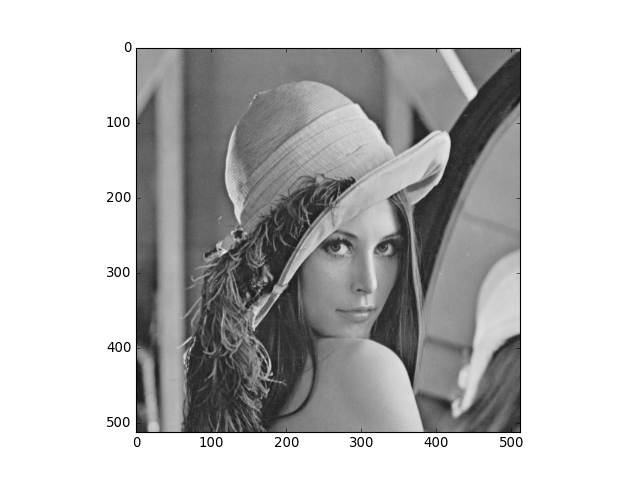

In [2]:
orig = plt.imread("data/lena.png")
plt.imshow(orig, cmap='gray', vmin=0, vmax=1)
plt.show()

**Create a new directory for the results and clean it up if it already exists.**

In [3]:
results_path = "sample_results"
if os.path.exists(results_path):
    shutil.rmtree(results_path)
os.mkdir(results_path)

**Create a logger/plotter objects to monitor the training progress.**

<IPython.core.display.Javascript object>


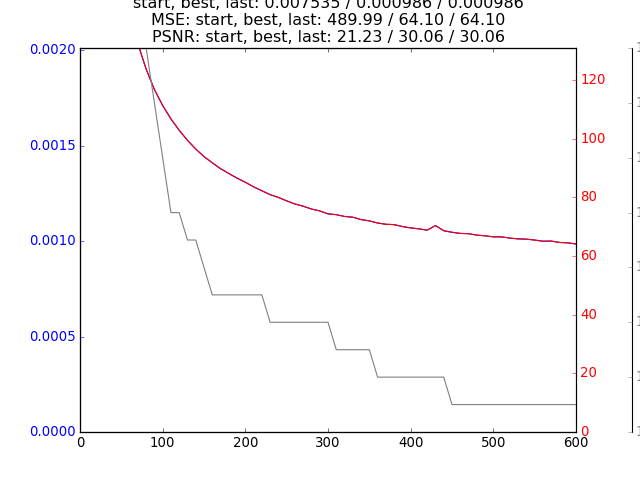

<IPython.core.display.Javascript object>


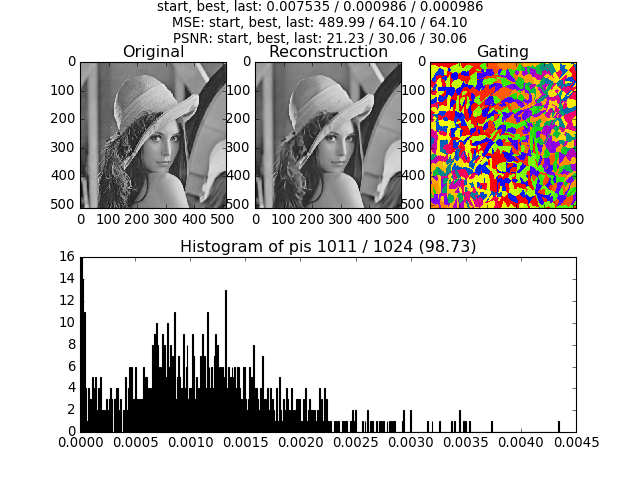

In [4]:
loss_plotter = LossPlotter(path=results_path + "/loss.png", quiet=False)
image_plotter = ImagePlotter(path=results_path, options=['orig', 'reconstruction', 'gating', 'pis_hist'], quiet=False)
logger = ModelLogger(path=results_path)

**Create a smoe object and initialize it with the image we want to model.
The number of kernels per dimension is set to 32, so we will have $32\times 32=1204$ kernels in total.
The number of batches is set to 8, which will still need 8-9GB of GPU memory. Increase this value if you have less memory availible.**

In [5]:
num_kernels_per_dim = 32
num_batches = 8
smoe = Smoe(image=orig, kernels_per_dim=num_kernels_per_dim, start_batches=num_batches)

**Create the optimizers for the training process. Optimizer3 is used for training the $A$ matrix of the kernels, optimizer2 is used to train the $\pi$ and optimizer1 is used for the remaining variables.
The main reason to use multiple optimizers is to allow for different learning rates as the gradients of the parameters are of different magnitudes. Hence, the sensitivity of the optimizers need to be set accordingly using different learning rates.**

In [6]:
base_lr = 0.001
optimizer1 = tf.train.AdamOptimizer(base_lr)
optimizer2 = tf.train.AdamOptimizer(base_lr/100)
optimizer3 = tf.train.AdamOptimizer(base_lr*1000)

**Perform the training for 600 iterations and plot the training progress every 10 iterations.
The results are saved in *results_path*, the progress can be observed with the previously created plotters.
The training should end at a PSNR of about 30dB. The training may not be converged yet but it is just enough for demonstration purposes.**

In [7]:
iterations = 600
validation_iterations = 10
%time smoe.train(iterations, val_iter=validation_iterations, optimizer1=optimizer1, optimizer2=optimizer2, optimizer3=optimizer3, \
                 callbacks=[loss_plotter.plot, image_plotter.plot, logger.log])

Model saved in file: sample_results/checkpoints/00000000_model.ckpt
Model saved in file: sample_results/checkpoints/00000100_model.ckpt
Model saved in file: sample_results/checkpoints/00000200_model.ckpt
Model saved in file: sample_results/checkpoints/00000300_model.ckpt
Model saved in file: sample_results/checkpoints/00000400_model.ckpt
Model saved in file: sample_results/checkpoints/00000500_model.ckpt
Model saved in file: sample_results/checkpoints/00000600_model.ckpt
end loss/mse:  0.000985728484010906 / 64.096994638443 @iter:  600
best loss/mse:  0.000985728484010906 / 64.096994638443
CPU times: user 10min 19s, sys: 3min 8s, total: 13min 27s
Wall time: 15min 12s


**You can see that in the previous step already some kernels dropped out of the model (the respective value of $\pi$ reached 0 or below).
Now we continue training the model with the same optimizers but an additional regularization coefficient of $\lambda_S=10$ for the $\pi$ values so that more kernels drop out to promote sparsity in our model.
To do so, we use new plotter/logger objects to not override the previous results.
After this is finished, the PSNR drops to a bit above 29dB, but half of the kernels are removed from the model.**

<IPython.core.display.Javascript object>


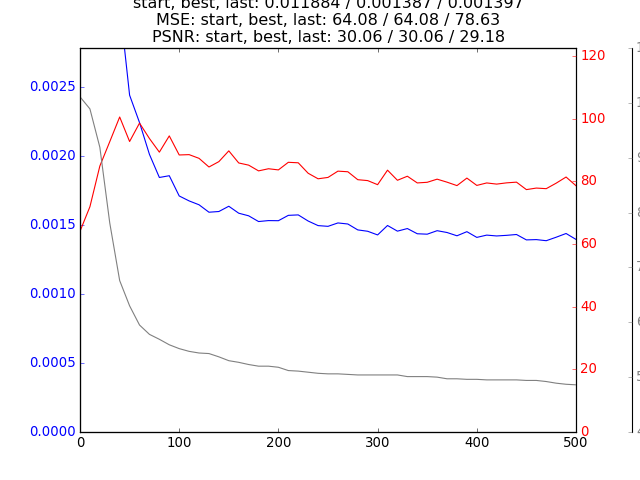

<IPython.core.display.Javascript object>


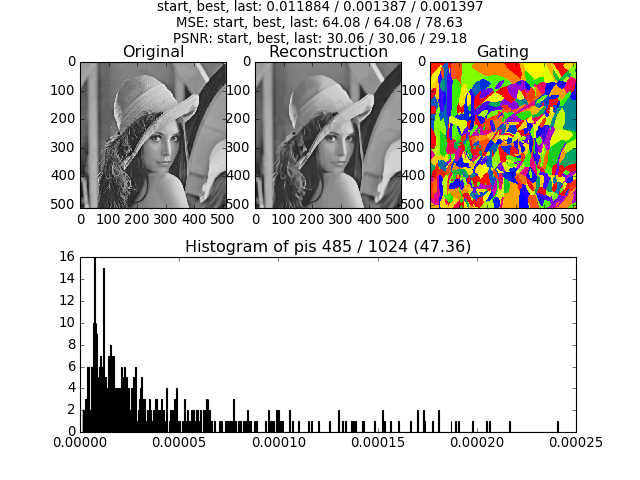

Model saved in file: sample_results_reg/checkpoints/00000600_model.ckpt
Model saved in file: sample_results_reg/checkpoints/00000100_model.ckpt
Model saved in file: sample_results_reg/checkpoints/00000200_model.ckpt
Model saved in file: sample_results_reg/checkpoints/00000300_model.ckpt
Model saved in file: sample_results_reg/checkpoints/00000400_model.ckpt
Model saved in file: sample_results_reg/checkpoints/00000500_model.ckpt
end loss/mse:  0.001396660227328539 / 78.62728500366211 @iter:  500
best loss/mse:  0.0013872954150428995 / 64.08499300479889
CPU times: user 5min 50s, sys: 2min 11s, total: 8min 1s
Wall time: 8min 8s


In [8]:
iterations = 500
validation_iterations = 10
l1reg = 10

results_path = "sample_results_reg"
if os.path.exists(results_path):
    shutil.rmtree(results_path)
os.mkdir(results_path)
loss_plotter = LossPlotter(path=results_path + "/loss.png", quiet=False)
image_plotter = ImagePlotter(path=results_path, options=['orig', 'reconstruction', 'gating', 'pis_hist'], quiet=False)
logger = ModelLogger(path=results_path)

%time smoe.train(iterations, val_iter=validation_iterations, optimizer1=optimizer1, optimizer2=optimizer2, optimizer3=optimizer3, \
                 pis_l1=l1reg, callbacks=[loss_plotter.plot, image_plotter.plot, logger.log])

**Finally, we continue the training with no regularization as final fine-tuning step for 100 iterations, which recovers the PSNR a bit from the previous drop of the regularized training.**

<IPython.core.display.Javascript object>


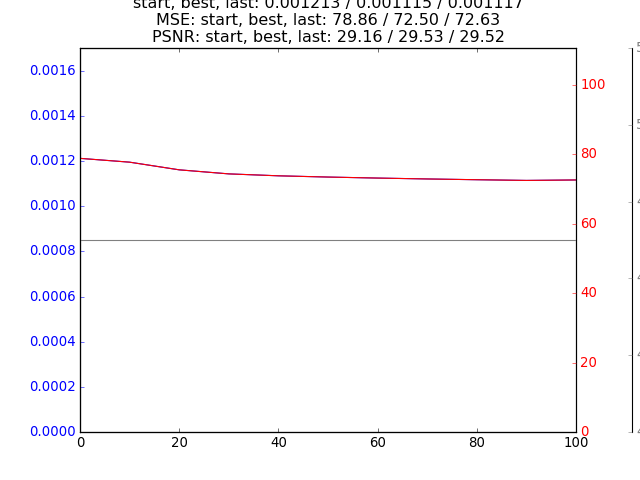

<IPython.core.display.Javascript object>


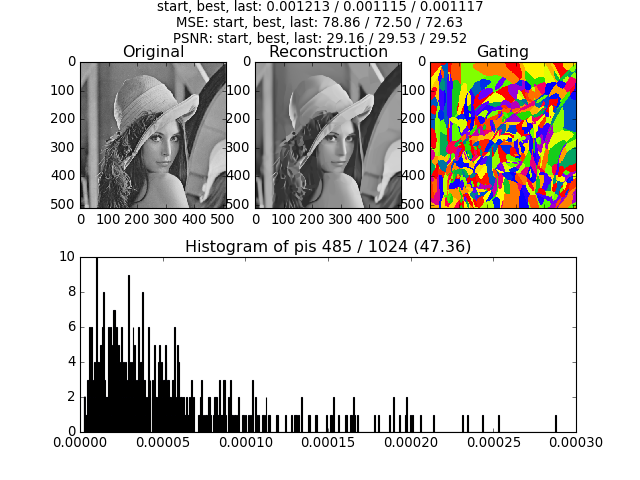

Model saved in file: sample_results_fine/checkpoints/00000500_model.ckpt
Model saved in file: sample_results_fine/checkpoints/00000100_model.ckpt
end loss/mse:  0.0011169542267452925 / 72.62994861602783 @iter:  100
best loss/mse:  0.0011149283818667755 / 72.49821710586548
CPU times: user 1min 7s, sys: 22.4 s, total: 1min 30s
Wall time: 1min 28s


In [9]:
iterations = 100
validation_iterations = 10
l1reg = 0

results_path = "sample_results_fine"
if os.path.exists(results_path):
    shutil.rmtree(results_path)
os.mkdir(results_path)
loss_plotter = LossPlotter(path=results_path + "/loss.png", quiet=False)
image_plotter = ImagePlotter(path=results_path, options=['orig', 'reconstruction', 'gating', 'pis_hist'], quiet=False)
logger = ModelLogger(path=results_path)

%time smoe.train(iterations, val_iter=validation_iterations, optimizer1=optimizer1, optimizer2=optimizer2, optimizer3=optimizer3, \
                 pis_l1=l1reg, callbacks=[loss_plotter.plot, image_plotter.plot, logger.log])